In [26]:
# Necessary imports
import zillow
import pprint
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

%matplotlib inline


In [6]:
#csv to pd dataframe

file1 = '/Users/nick/ds/metis/projects/proj2/Zillow/2018-04-24_004257.csv'
file2 = '/Users/nick/ds/metis/projects/proj2/Zillow/2018-04-25_152147.csv'
#scrapped from zillow 
files = [file1, file2]
pdlist =[]
for i in files:
    house_df = pd.read_csv(i)
    pdlist.append(house_df)

house_df = pd.concat(pdlist)
        
house_df.head()  

,address,bathrooms,bedrooms,city,price,sale_type,sqft,state,url,zip
0,3420 Vintage Valley Rd,3.0,4.0,ANN ARBOR,276.0,"SOLD: $710,000",NaN,MI,http://www.zillow.com/homes/for_sale//homedeta...,48105
1,657 Liberty Pointe Dr,3.0,3.0,ANN ARBOR,165.0,"SOLD: $246,500",NaN,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103
2,555 E William St APT 3A,1.0,1.0,ANN ARBOR,347.0,"SOLD: $242,000",NaN,MI,http://www.zillow.com/homes/for_sale//homedeta...,48104
3,1514 Saunders Cres,2.0,3.0,ANN ARBOR,217.0,"SOLD: $315,000",NaN,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103
4,4957 Gullane Dr,5.0,4.0,ANN ARBOR,144.0,"SOLD: $593,000",NaN,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103


In [9]:
#drop some useless columns
house_df=house_df.drop_duplicates()
house_df.drop('sqft', axis=1, inplace=True)
house_df.drop('price', axis=1, inplace=True)
#house_df.drop('sale_type', axis=1, inplace=True)
house_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 499
Data columns (total 9 columns):
address      949 non-null object
bathrooms    849 non-null float64
bedrooms     912 non-null float64
city         949 non-null object
price        419 non-null float64
sale_type    949 non-null object
state        949 non-null object
url          949 non-null object
zip          949 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 74.1+ KB


In [10]:
#reset index
house_df = house_df.reset_index(drop=True)

In [12]:
house_df.rename(columns={'sale_type': 'sale_price'}, inplace= True)

In [14]:
#get number values out of string
house_df['sale_price']=house_df.sale_price.str.replace(r'(\D+)', '')

In [15]:
house_df['sale_price'] = pd.to_numeric(house_df['sale_price'])

In [16]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 9 columns):
address       949 non-null object
bathrooms     849 non-null float64
bedrooms      912 non-null float64
city          949 non-null object
price         419 non-null float64
sale_price    949 non-null int64
state         949 non-null object
url           949 non-null object
zip           949 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 66.8+ KB


In [20]:
house_df.drop('price', axis=1, inplace=True)
house_df.head()

,address,bathrooms,bedrooms,city,sale_price,state,url,zip
0,3420 Vintage Valley Rd,3.0,4.0,ANN ARBOR,710000,MI,http://www.zillow.com/homes/for_sale//homedeta...,48105
1,657 Liberty Pointe Dr,3.0,3.0,ANN ARBOR,246500,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103
2,555 E William St APT 3A,1.0,1.0,ANN ARBOR,242000,MI,http://www.zillow.com/homes/for_sale//homedeta...,48104
3,1514 Saunders Cres,2.0,3.0,ANN ARBOR,315000,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103
4,4957 Gullane Dr,5.0,4.0,ANN ARBOR,593000,MI,http://www.zillow.com/homes/for_sale//homedeta...,48103


In [22]:
subset = ['address', 'bathrooms', 'bedrooms', 'sale_price', 'zip', 'url']
houses = house_df[subset]
#new df
house_df.corr()

,bathrooms,bedrooms,sale_price,zip
bathrooms,1.000000,0.605956,0.512852,-0.072306
bedrooms,0.605956,1.000000,0.316755,0.003953
sale_price,0.512852,0.316755,1.000000,-0.074611
zip,-0.072306,0.003953,-0.074611,1.000000


In [24]:
#create dummy variables for zipcode
Y = pd.get_dummies(houses.zip, drop_first=True)
houses1= houses.join(Y)

In [25]:
houses1.rename(columns={48104: '48104', 48105:'48105', 48108:'48108'}, inplace = True)
houses1.columns

Index([   'address',  'bathrooms',   'bedrooms', 'sale_price',        'zip',
              'url',      '48104',      '48105',      '48108',        48198],
      dtype='object')

In [27]:
#access api
key = 'xxxxx' #this is my unique ID required to call zillow api
api = zillow.ValuationApi()

In [34]:
address = '657 Liberty Pointe Dr, Ann Arbor MI'
zipcode ='48103'

In [35]:
data = api.GetDeepSearchResults(key, address, zipcode)

In [36]:
#api test
pp = pprint.PrettyPrinter(indent=4)    

pp.pprint(data.get_dict())

{   'extended_data': {   'bathrooms': '3.0',
                         'bedrooms': '3',
                         'complete': True,
                         'finished_sqft': '1450',
                         'fips_county': '26161',
                         'last_sold_date': '04/20/2018',
                         'last_sold_price': '246500',
                         'lot_size_sqft': None,
                         'tax_assessment': '207400.0',
                         'tax_assessment_year': '2017',
                         'usecode': 'Condominium',
                         'year_built': '1989'},
    'full_address': {   'city': 'ANN ARBOR',
                        'latitude': '42.273316',
                        'longitude': '-83.785723',
                        'state': 'MI',
                        'street': '657 Liberty Pointe Dr',
                        'zipcode': '48103'},
    'links': {   'comparables': 'http://www.zillow.com/homes/comps/24691181_zpid/',
                 'graphs_and_d

In [37]:

fin_sqft = []
bathrooms = []
bedrooms = []
last_sold_price = []
last_sold_date =[]
lot_size = []
year_built=[]
long = []
lat = []

zpid = []

for index, row in houses1.iterrows():
    address = row['address']+', Ann Arbor, MI'
    zip_code = str(row['zip'])
    try:
        data = api.GetDeepSearchResults(key, address, zipcode)
        
        fin_sqft.append(data.get_dict().get('extended_data').get('finished_sqft'))
        last_sold_date.append(data.get_dict().get('extended_data').get('last_sold_date'))
        lot_size.append(data.get_dict().get('extended_data').get('lot_size_sqft'))
        bathrooms.append(data.get_dict().get('extended_data').get('bathrooms'))
        bedrooms.append(data.get_dict().get('extended_data').get('bedrooms'))
        last_sold_price.append(data.get_dict().get('extended_data').get('last_sold_price'))
        year_built.append(data.get_dict().get('extended_data').get('year_built'))
        long.append(data.get_dict().get('full_address').get('longitude'))
        lat.append(data.get_dict().get('full_address').get('latitude'))
        zpid.append(data.get_dict().get('zpid'))

    except:
        fin_sqft.append(np.NaN)
        last_sold_date.append(np.NaN)
        lot_size.append(np.NaN)
        bathrooms.append(np.NaN)
        bedrooms.append(np.NaN)
        last_sold_price.append(np.NaN)
        year_built.append(np.NaN)
        long.append(np.NaN)
        lat.append(np.NaN)
        zpid.append(np.NaN)

In [39]:
#sanity check, should all be the same
print(len(fin_sqft), len(bathrooms), len(bedrooms ), len(last_sold_price ),
len(last_sold_date ), len(lot_size ), len(year_built), len(long ), len(lat ), len(zpid ))

949 949 949 949 949 949 949 949 949 949


In [40]:
df1 = pd.DataFrame({'fin_sqft':fin_sqft,'lot_size':lot_size,'year_built':year_built, 
                   'bathrooms1': bathrooms, 'bedrooms1' : bedrooms, 'price': last_sold_price,
                   'long':long, 'lat':lat, 'last_sold':last_sold_date ,'zpid':zpid})

df1.head()

,bathrooms1,bedrooms1,fin_sqft,last_sold,lat,long,lot_size,price,year_built,zpid
0,3.0,4,2778,04/23/2018,42.291509,-83.695405,27442,710000,1973,24698708
1,3.0,3,1450,04/20/2018,42.273316,-83.785723,None,246500,1989,24691181
2,1.0,1,696,04/20/2018,42.277991,-83.742518,None,242000,1969,24702044
3,2.0,3,1447,04/20/2018,42.294896,-83.77093,8712,315000,1958,24695810
4,5.0,4,4100,04/19/2018,42.279487,-83.825692,28749,593000,1998,54800658


In [41]:
df = houses1.join(df1)

In [44]:
df.dropna()

,address,bathrooms,bedrooms,sale_price,zip,url,48104,48105,48108,48198,bathrooms1,bedrooms1,fin_sqft,last_sold,lat,long,lot_size,price,year_built,zpid
0,3420 Vintage Valley Rd,3.0,4.0,710000,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,3.0,4,2778,04/23/2018,42.291509,-83.695405,27442,710000,1973,24698708
3,1514 Saunders Cres,2.0,3.0,315000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,2.0,3,1447,04/20/2018,42.294896,-83.77093,8712,315000,1958,24695810
4,4957 Gullane Dr,5.0,4.0,593000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,5.0,4,4100,04/19/2018,42.279487,-83.825692,28749,593000,1998,54800658
5,2424 Walter Dr,2.0,3.0,302500,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,2.0,3,1024,04/18/2018,42.28855,-83.780296,9017,302500,1958,24696164
6,2569 Page Ave,3.0,4.0,355000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,3.0,4,1876,04/16/2018,42.251201,-83.727467,10018,355000,1966,24718773
7,2981 Provincial Dr,4.0,4.0,770225,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,4.0,4,3110,04/16/2018,42.264699,-83.702721,21344,770225,1963,24709699
8,2118 Yorktown Dr,3.0,4.0,451100,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,3.0,4,2183,04/13/2018,42.305325,-83.697838,7840,451100,1964,24693681
10,809 Sycamore Pl,1.0,2.0,373000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,1.0,2,1144,04/13/2018,42.263598,-83.738073,5227,373000,1925,24708257
12,3073 Turnberry Ln,3.0,3.0,282800,48108,http://www.zillow.com/homes/for_sale//homedeta...,0,0,1,0,3.0,3,1893,04/12/2018,42.242011,-83.686919,5227,282800,1993,24722668
14,122 W Oakbrook Dr,2.0,2.0,296000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,2.0,2,1470,04/10/2018,42.247288,-83.756217,228000,296000,2005,63904101


In [46]:
df.drop('bedrooms1', axis=1, inplace=True)
df.drop('bathrooms1', axis =1, inplace =True)
df = df.reset_index(drop=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 18 columns):
address       949 non-null object
bathrooms     849 non-null float64
bedrooms      912 non-null float64
sale_price    949 non-null int64
zip           949 non-null int64
url           949 non-null object
48104         949 non-null uint8
48105         949 non-null uint8
48108         949 non-null uint8
48198         949 non-null uint8
fin_sqft      797 non-null object
last_sold     858 non-null object
lat           859 non-null object
long          859 non-null object
lot_size      724 non-null object
price         858 non-null object
year_built    759 non-null object
zpid          859 non-null object
dtypes: float64(2), int64(2), object(10), uint8(4)
memory usage: 107.6+ KB


In [49]:
df['fin_sqft'] = pd.to_numeric(df['fin_sqft'])
df['lot_size'] = pd.to_numeric(df['lot_size'])
df['price'] = pd.to_numeric(df['price'])
df['year_built'] = pd.to_numeric(df['year_built'])

In [51]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 0 to 947
Data columns (total 18 columns):
address       667 non-null object
bathrooms     667 non-null float64
bedrooms      667 non-null float64
sale_price    667 non-null int64
zip           667 non-null int64
url           667 non-null object
48104         667 non-null uint8
48105         667 non-null uint8
48108         667 non-null uint8
48198         667 non-null uint8
fin_sqft      667 non-null float64
last_sold     667 non-null object
lat           667 non-null object
long          667 non-null object
lot_size      667 non-null float64
price         667 non-null float64
year_built    667 non-null float64
zpid          667 non-null object
dtypes: float64(6), int64(2), object(6), uint8(4)
memory usage: 80.8+ KB


In [57]:
df.nsmallest(20, 'fin_sqft')

,address,bathrooms,bedrooms,sale_price,zip,url,48104,48105,48108,48198,fin_sqft,last_sold,lat,long,lot_size,price,year_built,zpid
839,304 W Delhi Rd,1.0,1.0,171000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,560.0,11/27/2017,42.290019,-83.81819,99752.0,171000.0,1937.0,54800305
406,1206 Broadway St,1.0,2.0,185000,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,690.0,12/22/2017,42.290687,-83.735802,9583.0,185000.0,1901.0,24698274
745,1206 Broadway St,1.0,2.0,185000,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,690.0,12/22/2017,42.290687,-83.735802,9583.0,185000.0,1901.0,24698274
74,2834 Elmwood St,1.0,1.0,155000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,710.0,03/20/2018,42.246733,-83.699256,8712.0,155000.0,1929.0,24716797
540,2834 Elmwood St,1.0,1.0,155000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,710.0,03/20/2018,42.246733,-83.699256,8712.0,155000.0,1929.0,24716797
793,812 Barton Dr,1.0,2.0,182000,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,720.0,12/07/2017,42.299901,-83.734355,7840.0,182000.0,1950.0,24698035
51,3225 Nordman Rd,1.0,2.0,186000,48108,http://www.zillow.com/homes/for_sale//homedeta...,0,0,1,0,735.0,03/23/2018,42.241697,-83.703354,8712.0,186000.0,1920.0,24722043
526,3225 Nordman Rd,1.0,2.0,186000,48108,http://www.zillow.com/homes/for_sale//homedeta...,0,0,1,0,735.0,03/23/2018,42.241697,-83.703354,8712.0,186000.0,1920.0,24722043
907,1215 Hutchins Ave,1.0,2.0,220000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,744.0,11/08/2017,42.265659,-83.756615,6534.0,220000.0,1940.0,24706722
371,507 S 5th Ave,1.0,1.0,181000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,750.0,01/02/2018,42.275902,-83.74595,4356.0,181000.0,1920.0,24702588


In [58]:
df = df[df.zpid != '80871035'] #remove some condos (not houses) that got in
df = df[df.zpid!='24692934']
df = df[df.zpid != '60380246']
df = df[df.zpid != '70892600']
df = df[df.zpid != '24693075']

df =df.drop_duplicates()

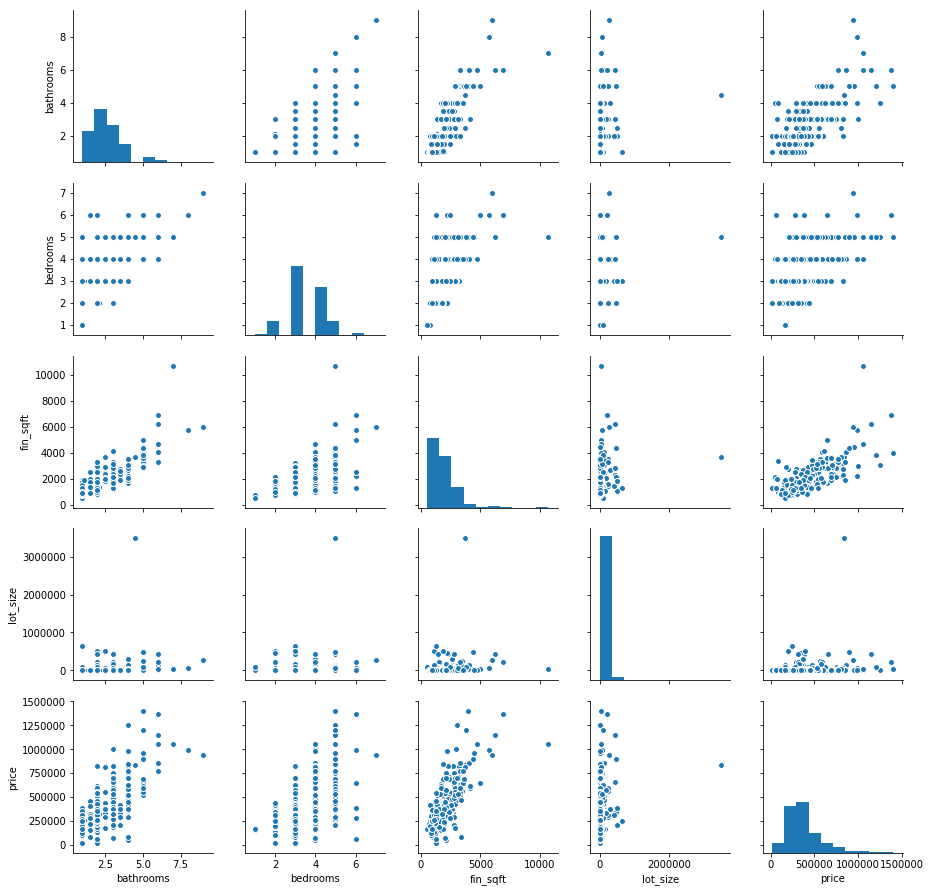

In [60]:
sns.pairplot(df[['bathrooms', 'bedrooms', 'fin_sqft', 'lot_size', 'price']])

In [61]:
#OLS
lsm = smf.ols('price~ bathrooms + bedrooms+ fin_sqft + lot_size', data = df)
fit1 = lsm.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     146.4
Date:                Fri, 27 Apr 2018   Prob (F-statistic):           4.99e-77
Time:                        18:04:39   Log-Likelihood:                -5366.3
No. Observations:                 406   AIC:                         1.074e+04
Df Residuals:                     401   BIC:                         1.076e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.012e+04   2.75e+04      1.825      0.069   -3856.616    1.04e+05
bathrooms   4.498e+04   9690.899      4.642      0.000    2.59e+04     6.4e+04
bedrooms    4987.1138   1.01e+04      0.495      0.621   -1.48e+04    2.48e+04
fin_sqft     108.4643     11.804      9.189      0.000      85.259     131.670
lot_size       0.0340      0.036      0.944      0.346      -0.037       0.105
==============================================================================
Omnibus:                       89.585   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.111
Skew:                           0.850   Prob(JB):                     8.94e-95
Kurtosis:                       7.766   Cond. No.                     8.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
#OLS with zip dummies
lsm = smf.ols('price~ bathrooms + bedrooms+ fin_sqft + Q("48104") + Q("48105") + Q("48108") ', data = df)

fit4 = lsm.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     111.5
Date:                Fri, 27 Apr 2018   Prob (F-statistic):           4.15e-82
Time:                        18:06:12   Log-Likelihood:                -5349.2
No. Observations:                 406   AIC:                         1.071e+04
Df Residuals:                     399   BIC:                         1.074e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.144e+04   2.73e+04      2.249      0.025    7722.932    1.15e+05
bathrooms    4.29e+04   9348.674      4.589      0.000    2.45e+04    6.13e+04
bedrooms    5960.8683   9696.435      0.615      0.539   -1.31e+04     2.5e+04
fin_sqft     105.0148     11.445      9.175      0.000      82.514     127.515
Q("48104")  3.161e+04   1.58e+04      2.005      0.046     616.432    6.26e+04
Q("48105")  1.414e+04   1.86e+04      0.759      0.448   -2.25e+04    5.07e+04
Q("48108") -1.017e+05   2.11e+04     -4.819      0.000   -1.43e+05   -6.02e+04
==============================================================================
Omnibus:                       82.859   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.410
Skew:                           0.709   Prob(JB):                    2.38e-106
Kurtosis:                       8.171   Cond. No.                     9.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

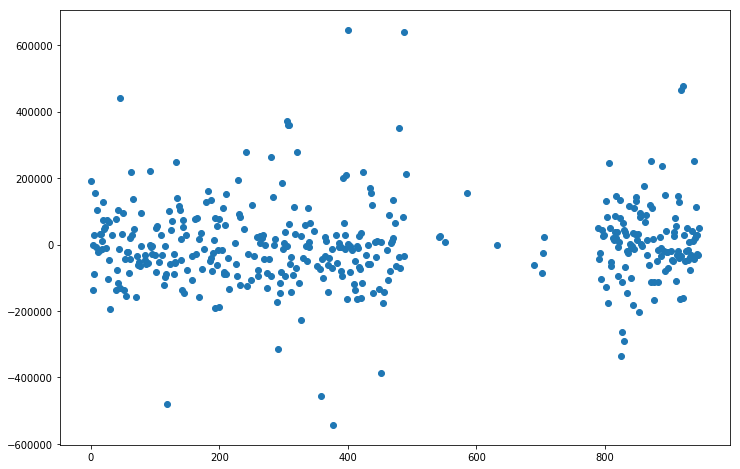

In [112]:
fit4.resid.plot(style='o', figsize=(12,8))
#residual errors

In [66]:
df['long'] = pd.to_numeric(df['long'])
df['lat'] = pd.to_numeric(df['lat'])


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 0 to 947
Data columns (total 18 columns):
address       406 non-null object
bathrooms     406 non-null float64
bedrooms      406 non-null float64
sale_price    406 non-null int64
zip           406 non-null int64
url           406 non-null object
48104         406 non-null uint8
48105         406 non-null uint8
48108         406 non-null uint8
48198         406 non-null uint8
fin_sqft      406 non-null float64
last_sold     406 non-null object
lat           406 non-null float64
long          406 non-null float64
lot_size      406 non-null float64
price         406 non-null float64
year_built    406 non-null float64
zpid          406 non-null object
dtypes: float64(8), int64(2), object(4), uint8(4)
memory usage: 69.2+ KB


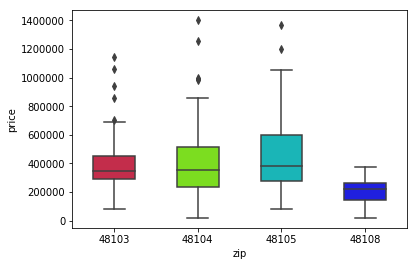

In [111]:
#price dist by zip
mypal =  ['crimson',"lawngreen", 'darkturquoise','blue']

bplot = sns.boxplot(y='price', x='zip', 
                 data=df, 
                 width=.5,
                 palette=mypal)

bplot.figure.savefig('bplot',
                    format='jpeg',
                    dpi=200)

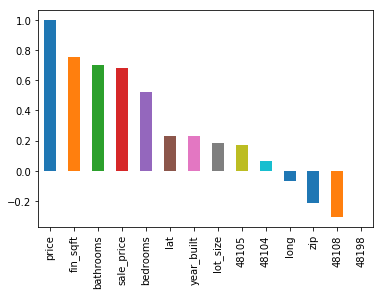

In [68]:
df.corr()['price'].sort_values(ascending=False).plot(kind='bar');

In [69]:
df

,address,bathrooms,bedrooms,sale_price,zip,url,48104,48105,48108,48198,fin_sqft,last_sold,lat,long,lot_size,price,year_built,zpid
0,3420 Vintage Valley Rd,3.0,4.0,710000,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,2778.0,04/23/2018,42.291509,-83.695405,27442.0,710000.0,1973.0,24698708
3,1514 Saunders Cres,2.0,3.0,315000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,1447.0,04/20/2018,42.294896,-83.770930,8712.0,315000.0,1958.0,24695810
4,4957 Gullane Dr,5.0,4.0,593000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,4100.0,04/19/2018,42.279487,-83.825692,28749.0,593000.0,1998.0,54800658
5,2424 Walter Dr,2.0,3.0,302500,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,1024.0,04/18/2018,42.288550,-83.780296,9017.0,302500.0,1958.0,24696164
6,2569 Page Ave,3.0,4.0,355000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,1876.0,04/16/2018,42.251201,-83.727467,10018.0,355000.0,1966.0,24718773
7,2981 Provincial Dr,4.0,4.0,770225,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,3110.0,04/16/2018,42.264699,-83.702721,21344.0,770225.0,1963.0,24709699
8,2118 Yorktown Dr,3.0,4.0,451100,48105,http://www.zillow.com/homes/for_sale//homedeta...,0,1,0,0,2183.0,04/13/2018,42.305325,-83.697838,7840.0,451100.0,1964.0,24693681
10,809 Sycamore Pl,1.0,2.0,373000,48104,http://www.zillow.com/homes/for_sale//homedeta...,1,0,0,0,1144.0,04/13/2018,42.263598,-83.738073,5227.0,373000.0,1925.0,24708257
12,3073 Turnberry Ln,3.0,3.0,282800,48108,http://www.zillow.com/homes/for_sale//homedeta...,0,0,1,0,1893.0,04/12/2018,42.242011,-83.686919,5227.0,282800.0,1993.0,24722668
14,122 W Oakbrook Dr,2.0,2.0,296000,48103,http://www.zillow.com/homes/for_sale//homedeta...,0,0,0,0,1470.0,04/10/2018,42.247288,-83.756217,228000.0,296000.0,2005.0,63904101


In [70]:
df = df.reset_index(drop=True)

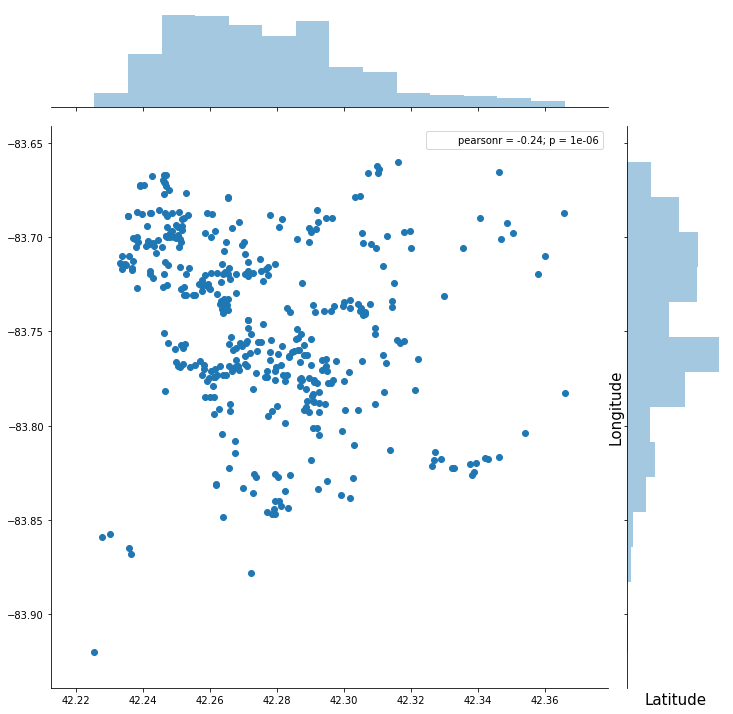

In [71]:
plt.figure(dpi = 300)
sns.jointplot(x=df.lat.values, y = df.long.values, size = 10)
plt.ylabel('Longitude', fontsize = 15)
plt.xlabel('Latitude', fontsize = 15)
plt.show();
sns.despine;

In [77]:
df['sqftsq'] = df['fin_sqft']**2 #sqaure of sqft

In [75]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [79]:
train1, test1 = train_test_split(df, test_size=0.3)

In [80]:
print(train1.shape)
print(test1.shape)
df.shape

(284, 19)
(122, 19)


(406, 19)

In [84]:
test1.columns

Index([   'address',  'bathrooms',   'bedrooms', 'sale_price',        'zip',
              'url',      '48104',      '48105',      '48108',        48198,
         'fin_sqft',  'last_sold',        'lat',       'long',   'lot_size',
            'price', 'year_built',       'zpid',     'sqftsq',      's_bed',
         's_sqftsq',     's_bath',      's_lot',     's_sqft'],
      dtype='object')

In [85]:
ss = StandardScaler()

train1['s_bed']= ss.fit_transform(train1[['bedrooms']])
test1['s_bed']= ss.transform(test1[['bedrooms']])

train1['s_sqftsq']= ss.fit_transform(train1[['sqftsq']])
test1['s_sqftsq']= ss.transform(test1[['sqftsq']])


train1['s_bath']= ss.fit_transform(train1[['bathrooms']])
test1['s_bath']= ss.transform(test1[['bathrooms']])

train1['s_lot']= ss.fit_transform(train1[['lot_size']])
test1['s_lot']= ss.transform(test1[['lot_size']])

train1['s_sqft']= ss.fit_transform(train1[['fin_sqft']])
test1['s_sqft']= ss.transform(test1[['fin_sqft']])


train1['syr_built']= ss.fit_transform(train1[['year_built']])
test1['syr_built']= ss.transform(test1[['year_built']])



/Users/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [86]:
x = train1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot']]
x1 = train1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot', '48104', '48105', '48108' ]]
x2 = train1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot', 's_sqftsq']]

y = train1['price']

x_test = test1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot']]
x1_test = test1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot', '48104', '48105', '48108' ]]
x2_test = test1[['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot', 's_sqftsq']]
y_test = test1['price']

In [87]:
lsm = smf.ols('price~ s_bath + s_bed+ s_sqft + s_lot', data = train1)
fit = lsm.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     96.62
Date:                Fri, 27 Apr 2018   Prob (F-statistic):           1.77e-51
Time:                        18:26:52   Log-Likelihood:                -3761.4
No. Observations:                 284   AIC:                             7533.
Df Residuals:                     279   BIC:                             7551.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.828e+05   8183.520     46.782      0.000    3.67e+05    3.99e+05
s_bath      5.696e+04   1.39e+04      4.102      0.000    2.96e+04    8.43e+04
s_bed       1.236e+04   1.09e+04      1.138      0.256   -9022.737    3.37e+04
s_sqft      1.036e+05   1.47e+04      7.069      0.000    7.48e+04    1.32e+05
s_lot      -1168.9704   8663.857     -0.135      0.893   -1.82e+04    1.59e+04
==============================================================================
Omnibus:                       70.044   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.927
Skew:                           0.897   Prob(JB):                     4.63e-76
Kurtosis:                       8.109   Cond. No.                         3.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [89]:
ridge = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1, 4, 8, 16, 20, 26, 30], cv=10)

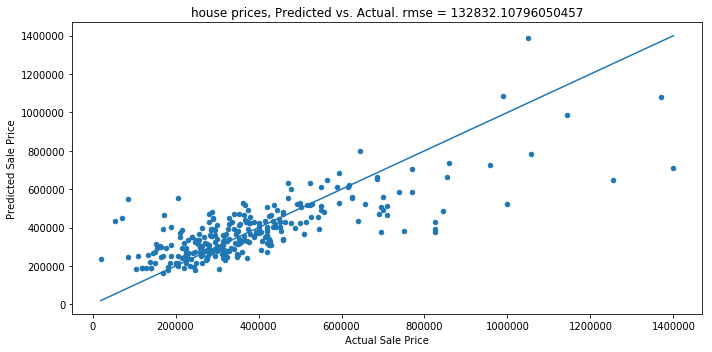

In [90]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

ridge.fit(x, y)
y_predicted = ridge.predict(X=x)
plt.figure(figsize=(10, 5))
plt.scatter(y, y_predicted, s=20)
rmse_pred_vs_actual = sqrt(mse(y_predicted, y))
plt.title(''.join(['house prices', ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot([min(y), max(y)], [min(y), max(y)])
plt.tight_layout() 

In [91]:
ridge.score(x_test, y_test)

0.6239550852051303

In [92]:
ridge.coef_

array([ 69368.53875033,  19922.54873651, -31610.03575141,  90181.50912249,
         7624.03895584])

In [93]:
x_test.columns

Index(['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot'], dtype='object')

In [94]:
ridge.intercept_

382843.57746478886

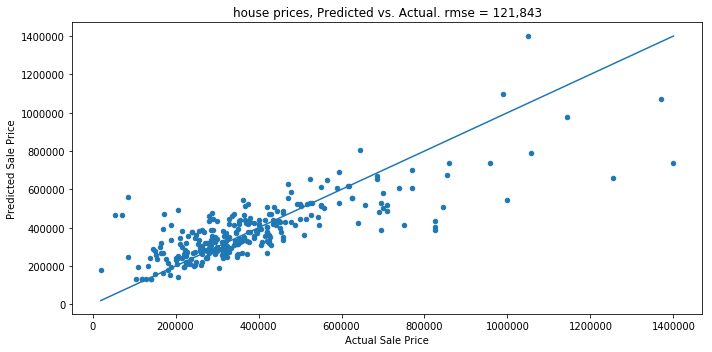

In [95]:
ridge1= RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1, 3, 5, 10, 15, 20, 25], cv=10)

ridge1.fit(x1, y)
y_predicted = ridge1.predict(X=x1)
plt.figure(figsize=(10, 5))
plt.scatter(y, y_predicted, s=20)
rmse_pred_vs_actual = sqrt(mse(y_predicted, y))
plt.title(''.join(['house prices', ', Predicted vs. Actual.', ' rmse = ', '121,843']))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot([min(y), max(y)], [min(y), max(y)])
plt.tight_layout() 

In [96]:
ridge1.score(x1_test, y_test)

0.6400802970602919

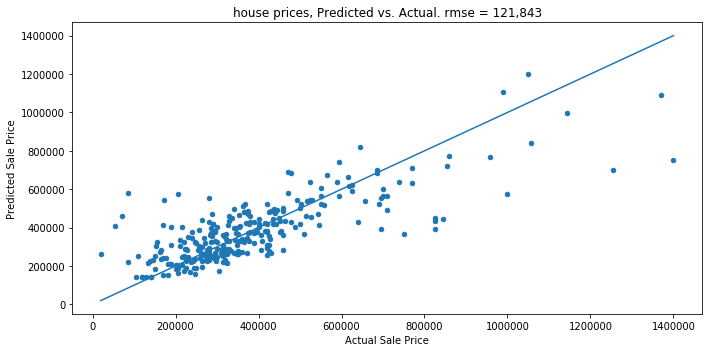

In [98]:
ridge2= RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1, 3, 5, 10, 15, 20, 25], cv=10)

ridge2.fit(x2, y)
y_predicted = ridge2.predict(X=x2)
plt.figure(figsize=(10, 5))
plt.scatter(y, y_predicted, s=20)
rmse_pred_vs_actual = sqrt(mse(y_predicted, y))
plt.title(''.join(['house prices', ', Predicted vs. Actual.', ' rmse = ', '121,843']))
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot([min(y), max(y)], [min(y), max(y)])
plt.tight_layout() 

In [100]:
ridge2.score(x2_test, y_test)

0.6745489906889212

In [108]:
print('intercept: ', ridge2.intercept_)
print('coeff: ',ridge2.coef_)

intercept:  382843.5774647889
coeff:  [ 59875.18824581   1798.35216046 -45337.20302049 189195.2475591
   2744.43125361 -70730.83946636]


In [109]:
x2.columns

Index(['s_bath', 's_bed', 'syr_built', 's_sqft', 's_lot', 's_sqftsq'], dtype='object')

In [121]:
err = ridge2.predict(x2_test)-y_test
y = [i for i in range(len(err))]

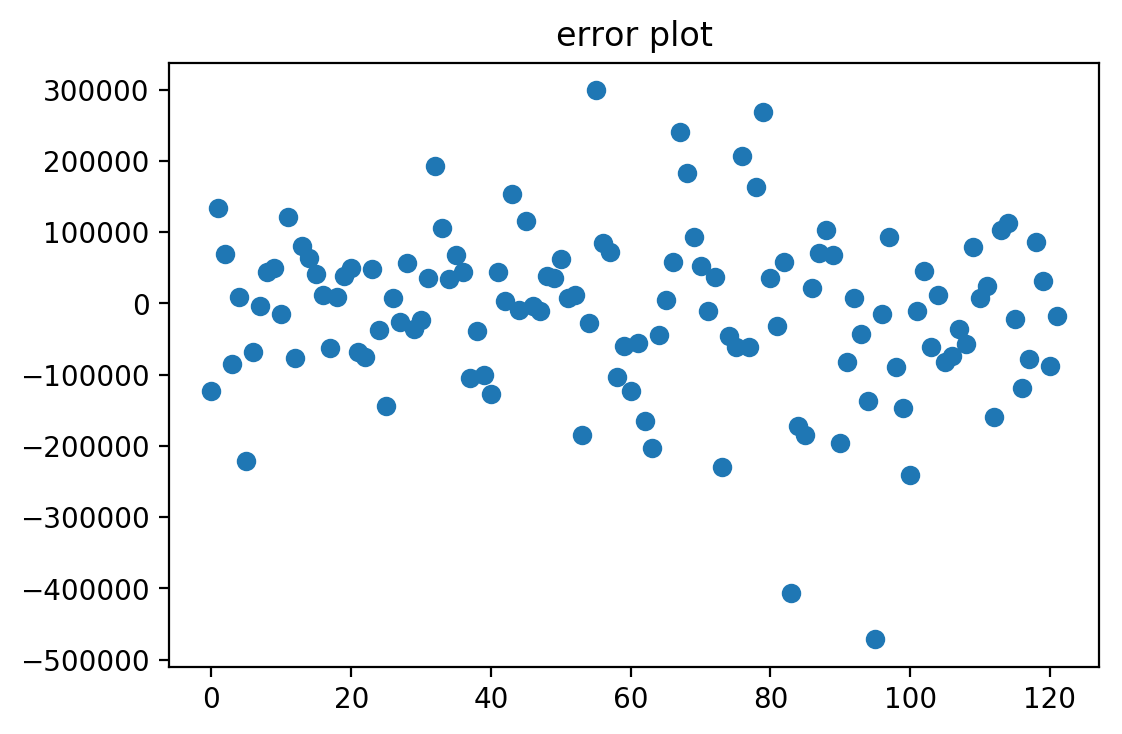

In [124]:
plt.figure(dpi = 200)
plt.scatter(y, err)
plt.title('error plot')
plt.show()